In [1]:
#### Import de libraries
import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import functions 
import scipy.stats as stats
from tabulate import tabulate
from sklearn.model_selection import train_test_split

In [2]:
# import de la base de données excel
warnings.filterwarnings("ignore")

data = pd.read_excel('sci.xlsx')

In [4]:
df= data.copy()
df.info()
# Jeu de données initial avec 67 colonnes et 495514 lignes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495514 entries, 0 to 495513
Data columns (total 67 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_client                    495514 non-null  int64         
 1   DDefaut_NDB                  495514 non-null  int64         
 2   datdelhis                    495514 non-null  int64         
 3   AGEPRS                       495514 non-null  int64         
 4   ANCIENNETE                   495514 non-null  int64         
 5   CODETAJUR                    495514 non-null  int64         
 6   CODITDBDF_PRO                495514 non-null  int64         
 7   CODNAF2                      495514 non-null  object        
 8   CODTYPPRS                    495514 non-null  int64         
 9   CRTAD_AG_MVTAFF_IND_0010     495514 non-null  int64         
 10  CRTAD_AG_NBECR_A             495514 non-null  int64         
 11  CRTAD_AG_NBECR_B          

### 0. Vérifications préliminaires
Questions à poser au prof : la variable CODPAY_RESIDENCE est elle illégale au sens RGPD ?

In [ ]:
# Suppression des variables illégales
var_illegales = ['CODPAY_NAISSANCE', 'CODPAY_NATIONALITE','CODSEXPRS','CODCMNIEE'] # CODPAY_RESIDENCE, CODPAY_NAISSANCE => 
df.drop(columns=var_illegales, inplace=True)
#=> 63 colonnes

In [5]:
# Vérification des doublons par ligne dans la base de données
print(df.duplicated().sum())

0


In [6]:
# Vérification des doublons par colonnes
all(df['CRTAD_AG_SOLDE_T']==df["CRTAE_AG_SLDEPA"])

False

In [7]:
print(f"{all(df['DATCREENT'==df['DATCREPRSENT']])=}")
df.drop(columns=['DATCREPRSENT'],inplace=True)
#=> 62 colonnes

all(df['DATCREENT'==df['DATCREPRSENT']])=True


##### Identification des variables explicatives catégorielles et des variables numériques

In [ ]:
importlib.reload(functions)

# Affichage des variables ayant un nombre de valeurs uniques inférieurs à 30 
# Le seuil de 30 est arbitraire
# retrait de variables date et defaut
result_df= functions.find_categorical_variables(df, 30)

----------------------------------------
Nombre total de variables ayant moins de 30 modalités : 20 

----------------------------------------
                  Variable  Unique_Count
10               DATCREENT             0
9   CRTOU_CCT_PRO_IND_0209             1
15               IND_ACTIF             1
14           TOP_PRO_ACTIF             1
13                  RATIO3             1
12                  RATIO1             1
11               INDPARDCD             1
18        secteur_activite             1
19    secteur_activite_bis             1
7        CRTOP_AG_IND_0038             1
6   CRTOD_CMT_PRO_IND_0209             1
8           CRTOP_IND_0038             1
4                CODTYPPRS             2
2            CODITDBDF_PRO             2
16              IND_PER_PM             2
0              DDefaut_NDB             2
3                  CODNAF2             4
17        CODPAY_RESIDENCE             5
1                datdelhis             6
5           CRTAD_IND_0062           

In [9]:
# Retrait de la variable CRTAD_IND_0062 car elle est quantitative discrète 
# Retrait des variables date et defaut, car ce ne sont pas des variables explicatives
# et des variables n'ayant qu'une modalité
pre_categorical_vars = [ col for col in result_df["Variable"][result_df["Unique_Count"]>=2]
                     if col not in ["CRTAD_IND_0062", "datdelhis", "DDefaut_NDB"]]
print(pre_categorical_vars)

for col in pre_categorical_vars:
    print(f"{col} : {df[col].dtypes}")

# Transformation des variables catégorielles en variables catégorielles
df[pre_categorical_vars] = df[pre_categorical_vars].astype('category')

['CODITDBDF_PRO', 'CODNAF2', 'CODTYPPRS', 'IND_PER_PM', 'CODPAY_RESIDENCE']
CODITDBDF_PRO : int64
CODNAF2 : object
CODTYPPRS : int64
IND_PER_PM : object
CODPAY_RESIDENCE : object


In [10]:
# Variables à exclure car elles n'ont qu'une modalité
vars_to_exclude = result_df["Variable"][result_df["Unique_Count"] <= 1].tolist() 

# Variables continues
pre_cont_vars = [col for col in df.columns if col not in (pre_categorical_vars + vars_to_exclude + ['id_client', 'DDefaut_NDB', 'datdelhis'])]
print(len(pre_cont_vars))

42


##### Identification des variables à une modalité au plus pour description des individus de la bdd

Notre jeu de données est constitué de SCI, ayant un indicateur actif = 0, avec des Montant des litiges (CRTOD_CMT_PRO_IND_0209), Somme des soldes moyens trimestre (m a m-2), soldes moyen (CRTOP_AG_IND_0038), cumul de litiges (CRTOU_CCT_PRO_IND_0209), Solde en jours de mouvement d'affaire (Ratio 1) et  Solde débiteur cumulé rapporté au mouvement d'affaire (Ratio 3) nuls.

In [11]:
for col in vars_to_exclude:
    print(f"{col} : {df[col].unique()}")

CRTOD_CMT_PRO_IND_0209 : [0]
CRTOP_AG_IND_0038 : [0]
CRTOP_IND_0038 : [0]
CRTOU_CCT_PRO_IND_0209 : [0]
DATCREENT : [nan]
INDPARDCD : [ 0. nan]
RATIO1 : [0]
RATIO3 : [0]
TOP_PRO_ACTIF : ['O']
IND_ACTIF : [1]
secteur_activite : ['SCI']
secteur_activite_bis : ['SCI']


In [12]:
# Retrait des variables n'apportant aucune information pour la prédiction (car à modalités uniques) et de la variable id_client
df.drop(columns=vars_to_exclude + ["id_client"] ,inplace=True)
# => 59 colonnes

In [13]:
print("Database après les modifications ")
df.info()
# Jeu de données avec 59 colonnes et 495514 lignes.

Database après les modifications 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495514 entries, 0 to 495513
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   DDefaut_NDB                  495514 non-null  int64   
 1   datdelhis                    495514 non-null  int64   
 2   AGEPRS                       495514 non-null  int64   
 3   ANCIENNETE                   495514 non-null  int64   
 4   CODETAJUR                    495514 non-null  int64   
 5   CODITDBDF_PRO                495514 non-null  category
 6   CODNAF2                      495514 non-null  category
 7   CODTYPPRS                    495514 non-null  category
 8   CRTAD_AG_MVTAFF_IND_0010     495514 non-null  int64   
 9   CRTAD_AG_NBECR_A             495514 non-null  int64   
 10  CRTAD_AG_NBECR_B             495514 non-null  int64   
 11  CRTAD_AG_NBJDE_BA            495514 non-null  int64   
 12  CRTAD_AG_N

# I. Identification de la variable cible et analyse des variables explicatives

## I.1. La variable cible 

In [14]:
cible = "DDefaut_NDB"
print("Type of target column")
print(df[[cible]].dtypes)

Type of target column
DDefaut_NDB    int64
dtype: object


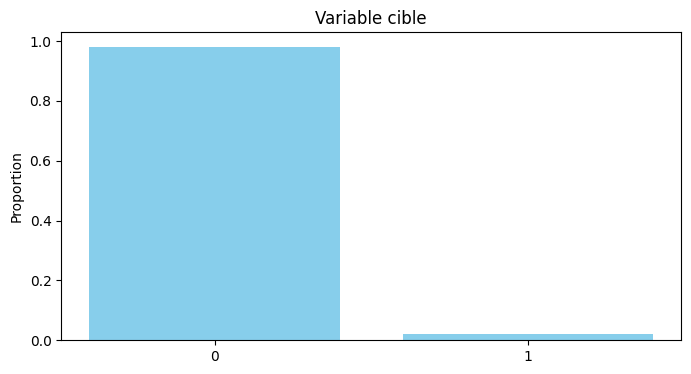

In [ ]:
# Create the bar plot
plt.figure(figsize=(8, 4))
plt.bar(df[cible].value_counts().index.astype(str), df[cible].value_counts(normalize=True), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [16]:
#Transformer le format de date :
date = "datdelhis"
print("Nombre de dates : ",df[['datdelhis']].nunique())
print("Format de date initial: ", df[['datdelhis']].dtypes)


df['datdelhis'] = pd.to_datetime(df['datdelhis'], format = '%Y%m')
print("Format de date final: ", df[['datdelhis']].dtypes)


Nombre de dates :  datdelhis    6
dtype: int64
Format de date initial:  datdelhis    int64
dtype: object
Format de date final:  datdelhis    datetime64[ns]
dtype: object


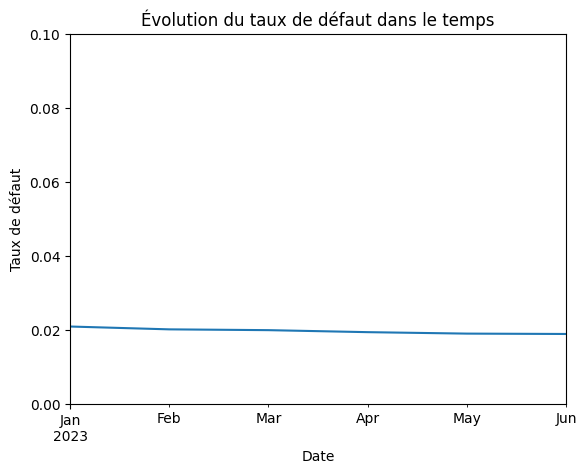

In [ ]:
# Evolution de la variable cible dans le temps

taux_cible = df.groupby(df['datdelhis'].dt.to_period('M'))['DDefaut_NDB'].mean() # ou sum()

# Tracer le taux de la variable cible au fil du temps
taux_cible.plot(title='Évolution du taux de défaut dans le temps')
plt.xlabel('Date')
plt.ylabel('Taux de défaut')
plt.ylim(0,0.1)
plt.show()

## I.2. Construction de la base d'échantillon

In [18]:
# Identification des variables catégorielles pouvant générer un biais de sélection dans le modèle
# Ces variables n'apportent aucune information pour la prédition de la variable cible car elles ne sont pas discrimantes

importlib.reload(functions)
df_var_surep = functions.find_uniq_mod_variables(df, pre_categorical_vars, 0.99)
var_surep = [col for col in df_var_surep["Variable"] if col not in ["DDefaut_NDB"]]

# retrait des variables surepresentées 
pre_categorical_vars = [col for col in pre_categorical_vars if col not in var_surep]

----------------------------------------
Nombre de variables ayant une modalité dominante à plus de 99.0% : 4
----------------------------------------
           Variable  Nb_mod Mod_dominante  Frequence
0     CODITDBDF_PRO       2             0   0.996587
1         CODTYPPRS       2             2   0.994987
2        IND_PER_PM       2            PM   0.994987
3  CODPAY_RESIDENCE       5           FRA   0.999655
----------------------------------------


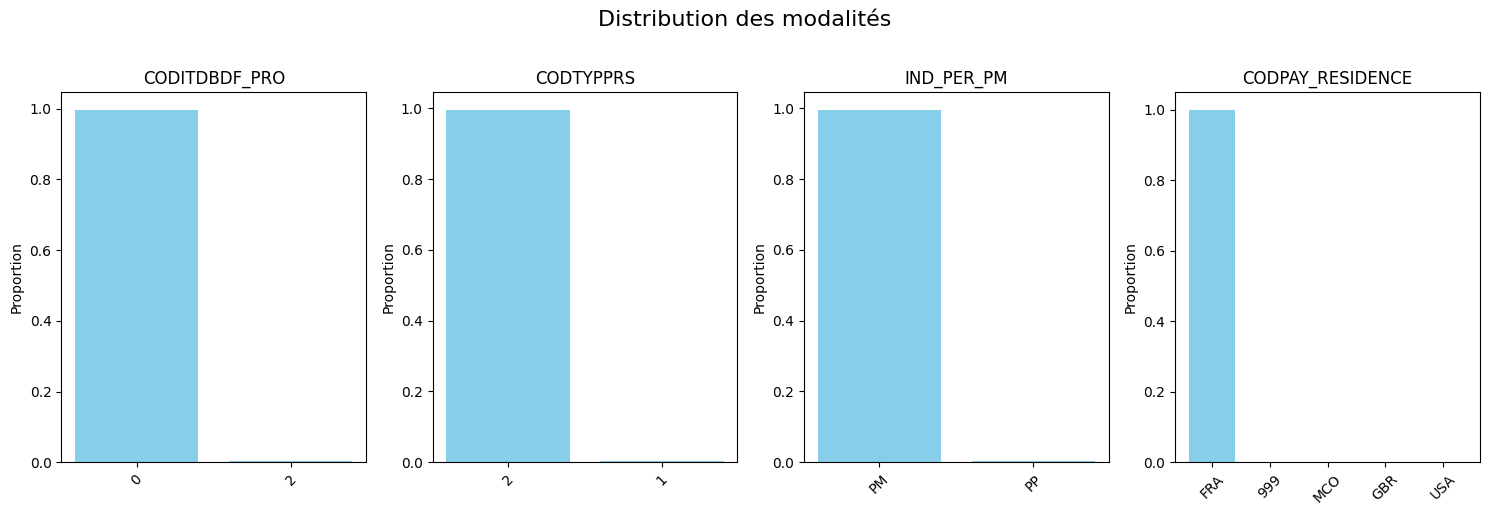

In [19]:
# Create the bar plot
importlib.reload(functions)
functions.plot_cat_vars_distributions(df, var_surep,cols=4)

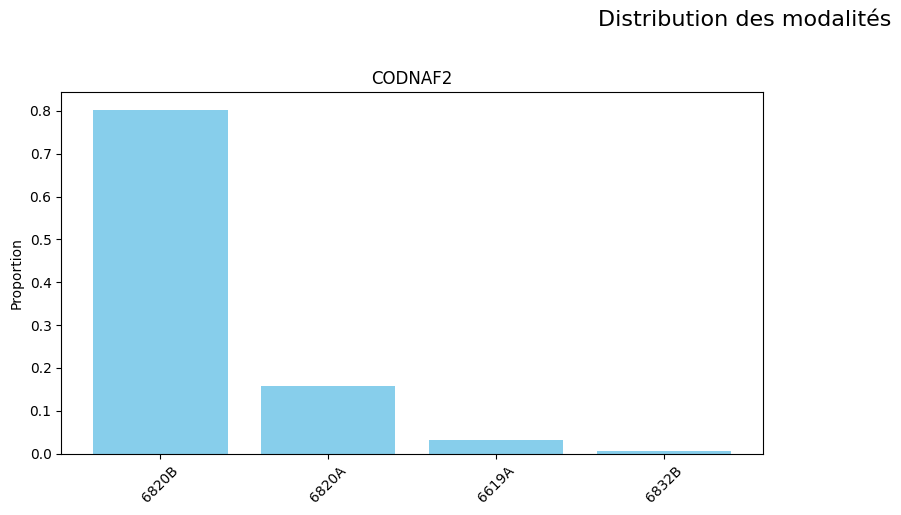

In [20]:
# Analyse des autres variables catégorielles
importlib.reload(functions)
functions.plot_cat_vars_distributions(df, [col for col in pre_categorical_vars if col not in var_surep], cols=2)

# Il n'y a que la variable CODNAF_2 qui n'a pas de modalité sureprésentée, cependant les classes sont déséquilibrées, il faudrait donc l'utiliser pour la stratification des données

In [ ]:
## Creation des echantillons train et test 

# Retrait des mauvaises variables de prédictions (variables ne prenant pratiquement qu'une seule modalité)
df_copy = df.copy()
X = df_copy.drop(columns = var_surep)
y = df_copy[cible]
X['stratify_col'] = df_copy[cible].astype(str) + '_' + df_copy['datdelhis'].astype(str) + '_' +  df_copy['CODNAF2'].astype(str) 

# Split train-test stratifié en utilisant la colonne combinée
X_train, X_test, y_train, y_test = train_test_split(
    X,  y,
    stratify=X['stratify_col'],  # La nouvelle colonne pour la stratification
    test_size=0.2,                # La proportion de l'ensemble de test
    random_state=42               # La graine pour la reproductibilité
)


In [22]:
# Suppression de la colonne de stratification car non utile pour la suite
X_train = X_train.drop(['stratify_col'], axis=1)
X_test = X_test.drop(['stratify_col'], axis=1)

#### I.2.1 Analyse de la représentativité des variables 

##### Variables ayant servis à la stratification

In [23]:
# Vérification de la répartition de la variable cible dans le train et le test

print("Répartition de la cible dans le train :")
print(y_train.value_counts(normalize=True))

print("\nRépartition de la cible dans le test :")
print(y_test.value_counts(normalize=True))


Répartition de la cible dans le train :
DDefaut_NDB
0    0.980374
1    0.019626
Name: proportion, dtype: float64

Répartition de la cible dans le test :
DDefaut_NDB
0    0.980374
1    0.019626
Name: proportion, dtype: float64


In [24]:
#### On verifie que la repartition des elements ayant servis à la stratification est la même dans nos echantillons train et test
# Vérification de la répartition des combinaisons dans la colonne de stratification

print("Répartition relative des dates d'observation dans le train :")
print(X_train['datdelhis'].value_counts(normalize=True))

print("\nRépartition relative des dates d'observation dans le test :")
print(X_test['datdelhis'].value_counts(normalize=True))



Répartition relative des dates d'observation dans le train :
datdelhis
2023-06-01    0.168388
2023-05-01    0.167720
2023-04-01    0.167236
2023-03-01    0.166620
2023-02-01    0.166040
2023-01-01    0.163996
Name: proportion, dtype: float64

Répartition relative des dates d'observation dans le test :
datdelhis
2023-06-01    0.168380
2023-05-01    0.167704
2023-04-01    0.167220
2023-03-01    0.166635
2023-02-01    0.166049
2023-01-01    0.164011
Name: proportion, dtype: float64


In [25]:
print("Répartition relative du secteur d'activité dans le train :")
print(X_train['CODNAF2'].value_counts(normalize=True))

print("\nRépartition relative du secteur d'activité dans le test :")
print(X_test['CODNAF2'].value_counts(normalize=True))

Répartition relative du secteur d'activité dans le train :
CODNAF2
6820B    0.803028
6820A    0.157569
6619A    0.032411
6832B    0.006993
Name: proportion, dtype: float64

Répartition relative du secteur d'activité dans le test :
CODNAF2
6820B    0.803033
6820A    0.157584
6619A    0.032401
6832B    0.006983
Name: proportion, dtype: float64


##### Variables continues

Analyses visuelles des distributions (KDE)


In [26]:
#### On peut également s'assurer que la distribution des variables continues est la même dans notre train et dans notre test 
#### Ce qui pourrait indiquer que notre stratification a capté l'ensemble des variables importantes.

### Nous avons donc choisi quelques variables que nous estimions pertinentes pour ce faire

# Liste des variables continues à analyser
var_a_analyser = ['AGEPRS','ANCIENNETE', 'CRTAD_AG_MVTAFF_IND_0010', 'CRTAD_AG_SOLDE_IND_0009', 
                       'CRTAR_IND_0036', 'CRTAD_AG_NBJDE_BA', 'CRTAD_IND_0062']


La variable "AGEPRS" est probablement à supprimer

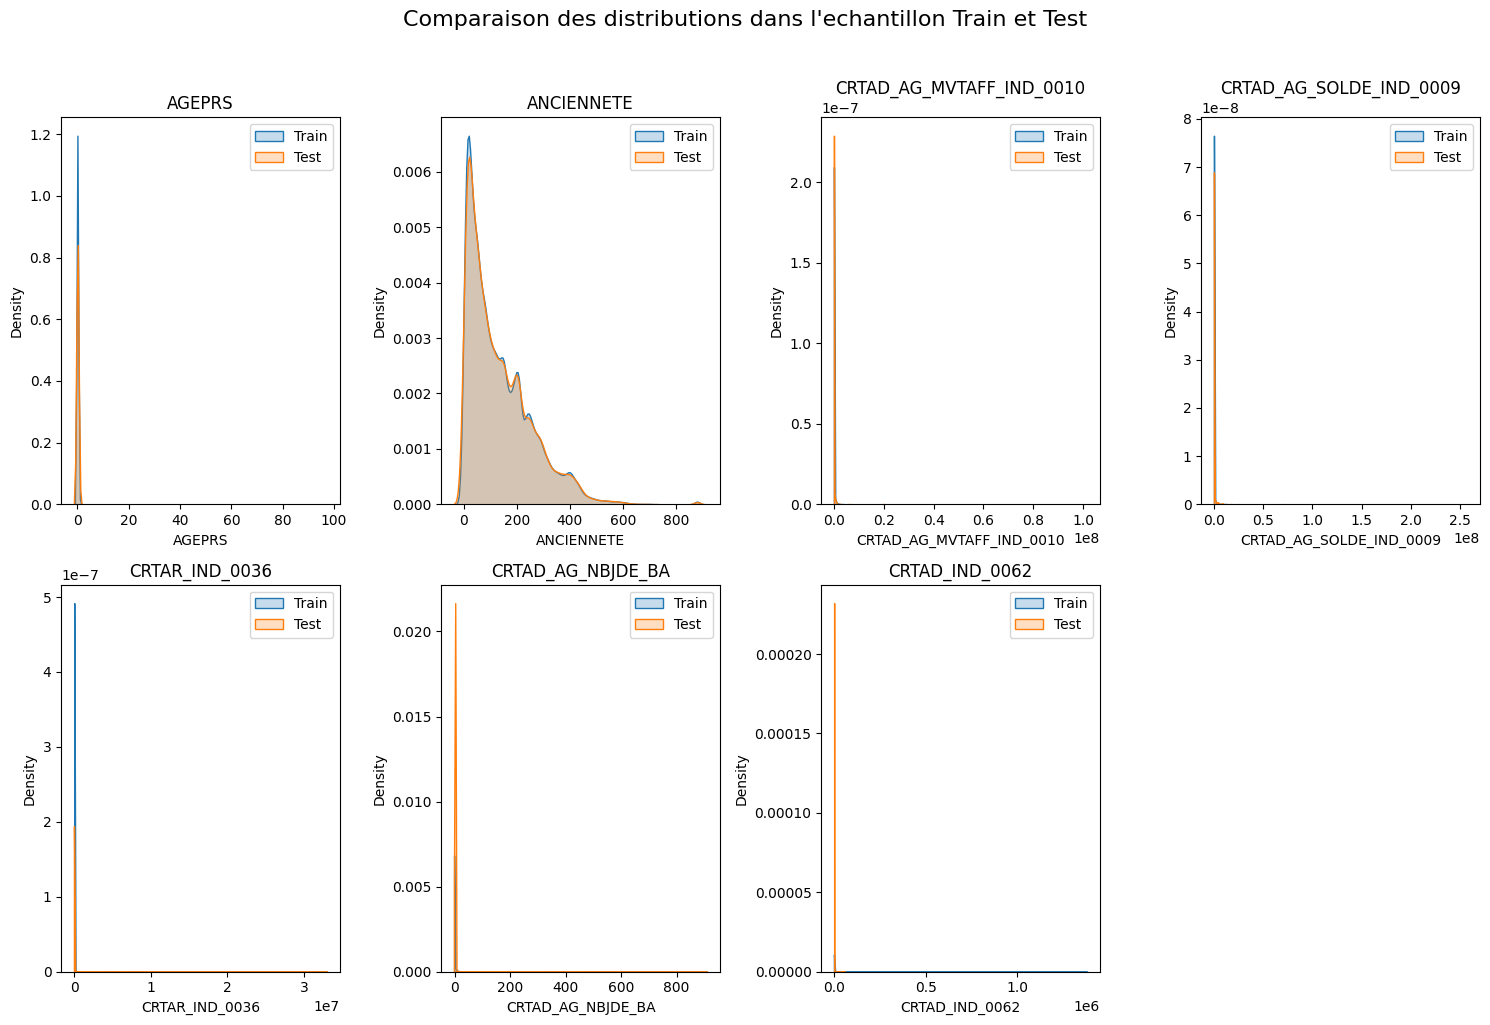

In [27]:
importlib.reload(functions)
functions.compare_distributions_grid(X_train, X_test, var_a_analyser, cols=4)

Analyse statistique de la représentativité

In [28]:
importlib.reload(functions)
functions.compare_distributions_summary(X_train, X_test, pre_cont_vars)

# Les distributions des variables continues sont similaires dans les échantillons train et test

,Variable,Train_Mean,Test_Mean,Train_Std,Test_Std,KS_Statistic,KS_p_value,Similar_Distribution
0,AGEPRS,3.003146e-01,3.199096e-01,4.372487e+00,4.545119e+00,0.000391,1.000000,Yes
1,ANCIENNETE,1.343660e+02,1.346389e+02,1.194232e+02,1.197109e+02,0.002933,0.501854,Yes
2,CODETAJUR,6.473105e+03,6.472619e+03,4.452317e+02,4.488154e+02,0.001060,0.999992,Yes
3,CRTAD_AG_MVTAFF_IND_0010,4.796051e+03,4.746626e+03,2.775689e+05,1.924476e+05,0.000174,1.000000,Yes
4,CRTAD_AG_NBECR_A,5.215597e-01,4.969981e-01,1.045736e+01,9.883302e+00,0.000199,1.000000,Yes
5,CRTAD_AG_NBECR_B,5.031899e-01,4.819228e-01,1.005405e+01,9.556310e+00,0.000207,1.000000,Yes
6,CRTAD_AG_NBJDE_BA,2.462520e-01,2.499420e-01,8.516190e+00,8.345475e+00,0.000164,1.000000,Yes
7,CRTAD_AG_NBJDE_BB,5.144660e-02,5.012966e-02,1.966218e+00,1.900597e+00,0.000053,1.000000,Yes
8,CRTAD_AG_NBJDE_BC,4.501893e-02,5.076537e-02,1.772380e+00,1.842274e+00,0.000177,1.000000,Yes
9,CRTAD_AG_SOLDE_IND_0009,1.592789e+04,1.563829e+04,7.595664e+05,6.391658e+05,0.000270,1.000000,Yes


In [ ]:
# Comparer la distribution de chaque variable continue dans le train et le test


# # Comparer la distribution de chaque variable continue dans le train et le test
# for var in var_a_analyser:
#     # Calcul des statistiques descriptives pour train et test
#     print(f"Statistiques descriptives de {var} dans le train :")
#     print(X_train[var].describe())
#     print(f"\nStatistiques descriptives de {var} dans le test :")
#     print(X_test[var].describe())
    
#     # Test de Kolmogorov-Smirnov pour vérifier si les distributions sont similaires
#     ks_stat, ks_p_value = stats.ks_2samp(X_train[var], X_test[var])
#     print(f"\nTest de Kolmogorov-Smirnov pour {var}: p-value = {ks_p_value}")
#     if ks_p_value > 0.05:
#         print("Les distributions sont similaires (p-value > 0.05).")
#     else:
#         print("Les distributions ne sont pas similaires (p-value < 0.05).")
#     print("\n" + "-"*50)


## I.3. Création de nouveaux indicateurs et pré-sélection des variables candidates à l’explication de la variable cible

#### I.3.1 Pré-selection des variables
On s'assure que nos données soient fiables, homogènes dans le temps et cohérentes.
##### Fiabilité

In [29]:
### Fiables
# Calculer le taux de valeurs manquantes (en pourcentage) pour chaque colonne
missing_percentages = X_train.isna().mean() * 100

# Filtrer uniquement les colonnes avec des valeurs manquantes
missing_columns = missing_percentages[missing_percentages > 0]

# Afficher le nombre de colonnes avec des valeurs manquantes
print(f"Nombre de colonnes avec des valeurs manquantes : {len(missing_columns)}")

# Afficher le taux de valeurs manquantes uniquement pour ces colonnes
if len(missing_columns) > 0:
    print("\nTaux de valeurs manquantes par colonne (%):")
    print(missing_columns)


Nombre de colonnes avec des valeurs manquantes : 0


On éludera le traitement des outliers ici vu que l'on segmentera nos données plustard

##### Homogenéité temporelle

Verifions que nos données catégorielles sont homogènes dans le temps, qu'il n'y a pas apparition et disparition  d'une modalité par exemple


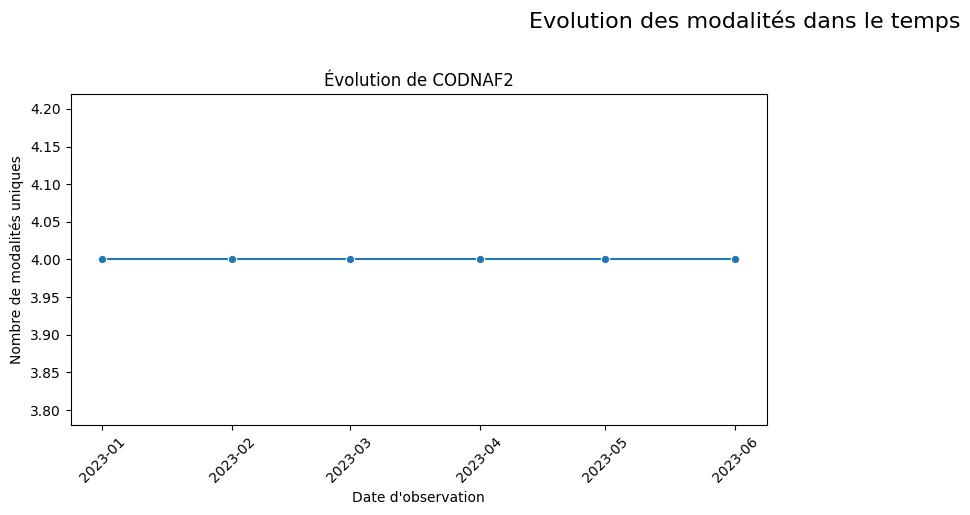

In [30]:
importlib.reload(functions)
functions.plot_modalities_over_time(X_train, "datdelhis", pre_categorical_vars)

In [ ]:


# # Créer un DataFrame vide pour stocker les informations pour la visualisation
# modalities_over_time = []
# categorical_vars = [ col for col in categorical_vars if col not in ["DDefaut_NDB", "datdelhis"]+var_surep]

# # Itérer sur les dates d'observation dans la colonne 'datdelhis'
# for date in X_train['datdelhis'].unique():
#     # Filtrer les données pour la date spécifique
#     filtered_data = X_train[X_train['datdelhis'] == date]
    
#     # Boucle sur chaque colonne catégorielle
#     for col in categorical_vars:
#         # Compter les modalités uniques pour cette date et colonne
#         modalities = filtered_data[col].unique()  # Valeurs distinctes des modalités
#         modalities_count = len(modalities)  # Compter le nombre de modalités uniques
        
#         # Ajouter les résultats à la liste
#         modalities_over_time.append({
#             'date': date,
#             'variable': col,
#             'modalities_count': modalities_count
#         })

# # Convertir la liste en DataFrame pour faciliter la visualisation
# modalities_df = pd.DataFrame(modalities_over_time)

# # Affichage des modalités par date et variable
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=modalities_df, x='date', y='modalities_count', hue='variable', marker='o')

# # Améliorer l'apparence du graphique
# plt.title("Évolution du nombre de modalités uniques par variable au fil du temps")
# plt.xlabel("Date d'observation")
# plt.ylabel("Nombre de modalités uniques")
# plt.xticks(rotation=45)  # Rotation des dates pour une meilleure lisibilité
# plt.legend(title="Variables", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

# # Afficher le graphique
# plt.show()


##### Cohérences et pertinences des variables
On s'assure de la cohérence et de la pertinence des variables de notre base

In [32]:
# Calcul des statistiques descriptives pour la colonne 'ANCIENNETE'
anciennete_stats = X_train['ANCIENNETE'].describe()

# Affichage des statistiques descriptives
print("Statistiques descriptives de la colonne 'ANCIENNETE' :")
print(anciennete_stats)

Statistiques descriptives de la colonne 'ANCIENNETE' :
count    396411.000000
mean        134.365999
std         119.423212
min           0.000000
25%          39.000000
50%         101.000000
75%         202.000000
max         881.000000
Name: ANCIENNETE, dtype: float64


Cette variable doit probablement être exprimée en jours et non en mois comme stipulé dans le dictionnaire de données.

#### I.3.2 Creation de nouveaux indicateurs

In [33]:
X_train['SECTNAF'] = X_train['CODNAF2'].str[-1]  ### On regroupe les seceurs d'activité en deux
#df["ANCENT"]= df['datdelhis'].dt.month - df['DATCREENT'].dt.month  ### On cree une nouvelle variable pour l'ancienneté de la SCI

categorical_vars = pre_categorical_vars + ['SECTNAF']
## cet indicateur ne pourra pas être calculé anyway

In [ ]:
#### Creation des indicateurs , ratios entre les indicateurs financiers courant et ceux d'il y a un an
# Créer une liste des indicateurs financiers courants
indicateurs_courants = ['CRTAD_AG_NBECR_A','CRTAD_AG_NBJDE_BB']
indicateurs_anterieurs = ['CRTAD_AG_NBECR_B', 'CRTAD_AG_NBJDE_BC' ]

## Creer de nouvelles variables dans notre dataframe df correspondant aux ratios entre les deux variables
df['ratio_NBECR'] = df['CRTAD_AG_NBECR_A'] / df['CRTAD_AG_NBECR_B']
df['ratio_NBJDE'] = df['CRTAD_AG_NBJDE_BB'] / df['CRTAD_AG_NBJDE_BC']

In [34]:
#### On construit une nouvelle variable matérialisant l'ancienneté de la relation entre la SCI et la LCL
#### mais cette fois exprimée en mois

# Conversion de l'ancienneté (en jours) en mois (approximativement 30 jours par mois)
X_train['ANCIENNETE_MOIS'] = df['ANCIENNETE'] / 30
X_train['ANCIENNETE_MOIS'].describe()

cont_vars = pre_cont_vars + ['ANCIENNETE_MOIS']

# II- Selection des variables

Les variables catégorielles ont déja été traitées dans la partie précédente (au niveau de la stratification de la base)

In [35]:
print(cont_vars)
print(categorical_vars)

['AGEPRS', 'ANCIENNETE', 'CODETAJUR', 'CRTAD_AG_MVTAFF_IND_0010', 'CRTAD_AG_NBECR_A', 'CRTAD_AG_NBECR_B', 'CRTAD_AG_NBJDE_BA', 'CRTAD_AG_NBJDE_BB', 'CRTAD_AG_NBJDE_BC', 'CRTAD_AG_SOLDE_IND_0009', 'CRTAD_AG_SOLDE_T', 'CRTAD_AG_SOLDE_T1', 'CRTAD_AG_SOLDE_T2', 'CRTAD_AG_SOLDE_T3', 'CRTAD_AG_SOLDE_T4', 'CRTAD_IND_0015', 'CRTAD_IND_0038', 'CRTAD_IND_0062', 'CRTAD_IND_0205', 'CRTAE_AG_SLDEPA', 'CRTAR_IND_0036', 'CRTOC_AG_LIGCRE_2T_IND_0009', 'CRTOC_AG_LIGCRE_IND_0009', 'CRTOC_AG_LIGDEB_2T_IND_0015', 'CRTOC_AG_LIGDEB_IND_0015', 'CRTOC_AG_MVTAFF_2T_IND_0010', 'CRTOC_AG_MVTAFF_IND_0010', 'CRTOC_AG_NBJCRE_2T_IND_0009', 'CRTOC_AG_NBJDEB_2T_IND_0015', 'CRTOC_AG_NBJDEB_IND_0015', 'CRTOC_IND_0010', 'CRTOC_IND_0015', 'CRTOC_IND_0164', 'CRTOC_IND_0301', 'CRTOC_MOY_MVTAFF_IND_0010', 'CRTOC_SLD_MOY', 'CRTOD_CMT_IND_0036', 'DATRLNORG', 'MINSOLDE_PAR', 'NBECR_PAR', 'CRTAD_IND_0042', 'CODACVPRO', 'ANCIENNETE_MOIS']
['CODNAF2', 'SECTNAF']


### II.1. Variables catégorielles
#### II.1.1 Statistiques descriptives pour les variables catégorielles

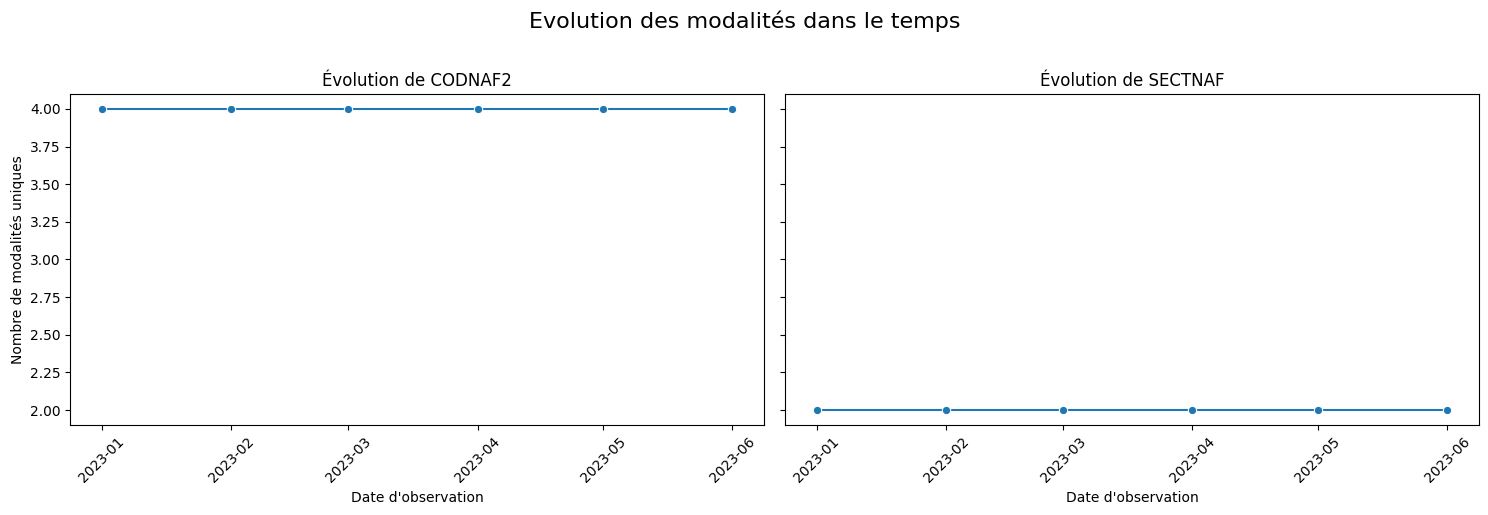

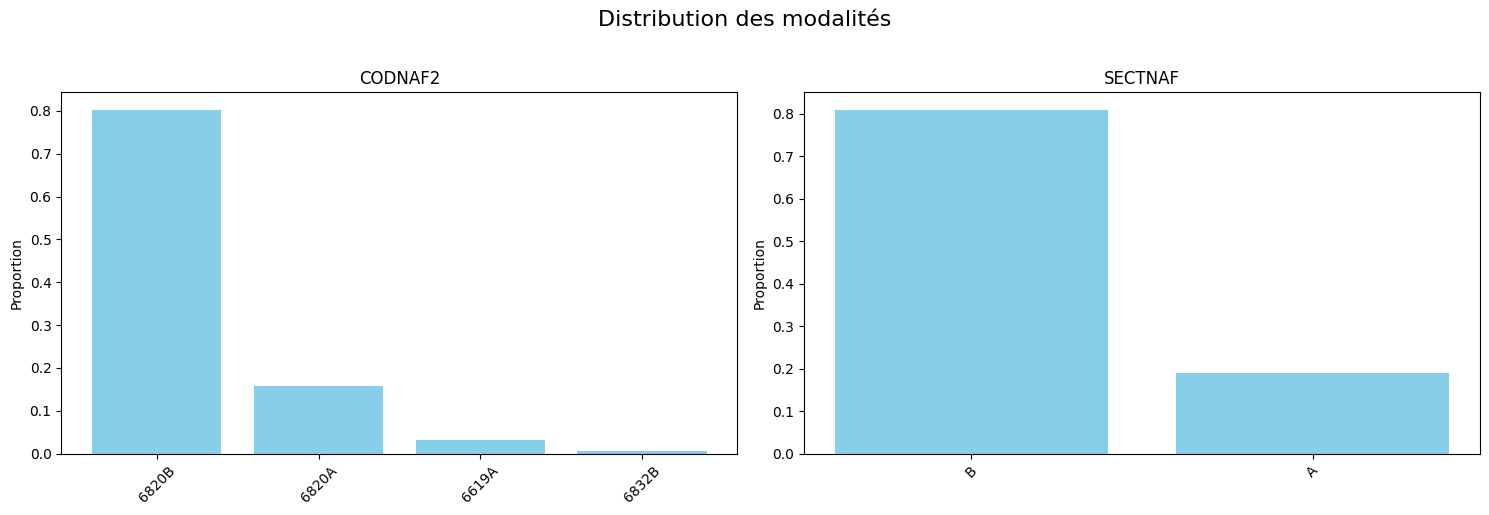

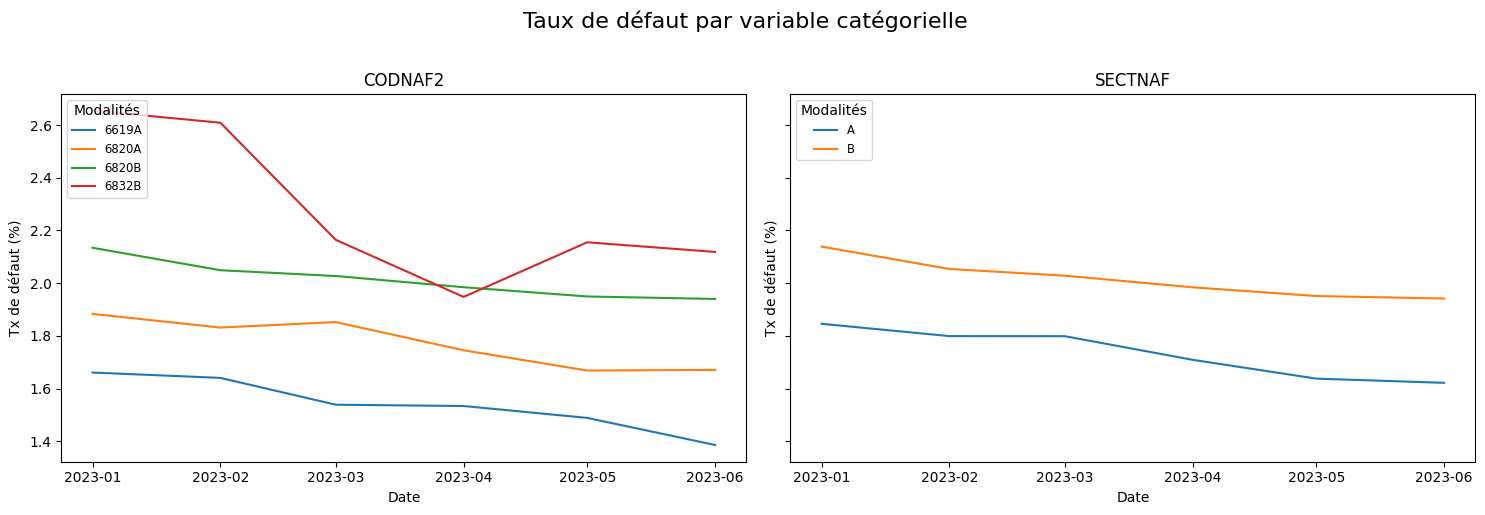

In [ ]:
importlib.reload(functions)
functions.plot_modalities_over_time(X_train, "datdelhis", categorical_vars)
functions.plot_cat_vars_distributions(X_train, categorical_vars, cols=2)
functions.tx_rsq_par_var(X_train,categorical_vars,date,cible)
functions.combined_barplot_lineplot(X_train, categorical_vars, cible)


On peut voir que le taux de défaut dans le temps est constant dans le temps selon le secteur d'activité. Le secteur d'activité B ( Locations de biens non-résidentiels) est plus risqué que le secteur d'activité A ( Locations de biens résidentiels). De plus, au sein même du secteur d'activité B, le taux de défaut est plus élevé pour les SCI avec un code NAF 6832B.

In [ ]:
### FAIRE UNE FONCTION QUI CALCULE L'ECART RELATIF DE TAUX DE RISQUES ENTRE LES MODALITES 

#### II.1.2. Liaisons avec la variable cible

In [203]:
importlib.reload(functions)
cramer_cible_res=functions.compute_cramers_v(X_train, categorical_vars,cible).sort_values(by = "Cramer_V", ascending=True).round(3)

Text(0.5, 1.0, 'Variables catégorielles dépendantes de la variable cible')

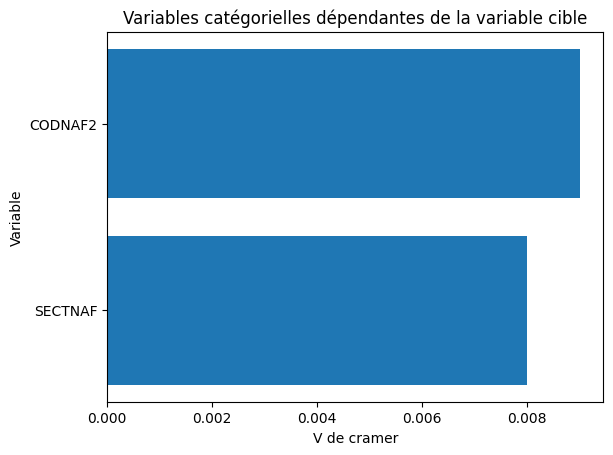

In [204]:
plt.barh(cramer_cible_res['Columns'], cramer_cible_res["Cramer_V"])

# Ajoutez des étiquettes et un titre
plt.xlabel('V de cramer')
plt.ylabel('Variable')
plt.title('Variables catégorielles dépendantes de la variable cible')


Le secteur d'activité n'est pas corrélé à la variable cible. En effet, pour les deux segmentations du code NAF, on obtient un V de cramer inferieur à 1%.

In [205]:
signif_cat_var=(cramer_cible_res[cramer_cible_res['Cramer_V']>0.05]['Columns']).to_list()

len(signif_cat_var)
print(signif_cat_var)

[]


#### II.1.3. Liaisons entre les variables catégorielles


In [ ]:
importlib.reload(functions)
p_value_df,cramer_v_df=functions.stats_liaisons_var_quali(X_train,categorical_vars)
np.fill_diagonal(cramer_v_df.values, 1)

<Axes: >

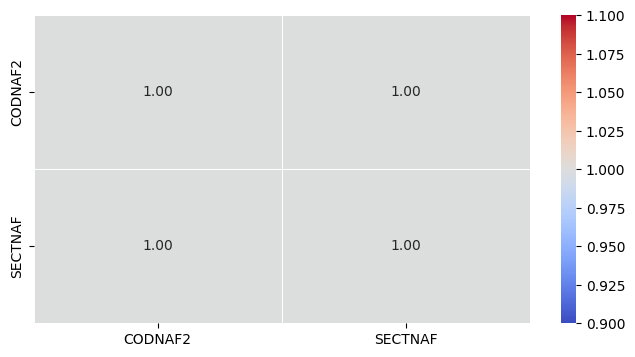

In [213]:
# Créer la heatmap
plt.figure(figsize=(8, 4))  # Vous pouvez ajuster la taille de la figure si nécessaire
sns.heatmap(cramer_v_df.astype(float), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

Sans surprise, mes deux variables sont très correlées. Il faudrait peut-être garder la variable secteur d'activité bien que la moins corrélée avec la variable cible car elle ne présente pas d'inversion de risque et les taux de défauts par modalité sont stables dans le temps.

### II.2. Variables continues

#### II.2.1 Statistiques descriptitves univariées des variables continues
Analyse visuelles des distributions

In [6]:
df['DATRLNORG'].describe()

count    4.955140e+05
mean     2.011721e+07
std      9.817553e+04
min      1.950010e+07
25%      2.006052e+07
50%      2.014111e+07
75%      2.020012e+07
max      2.023063e+07
Name: DATRLNORG, dtype: float64

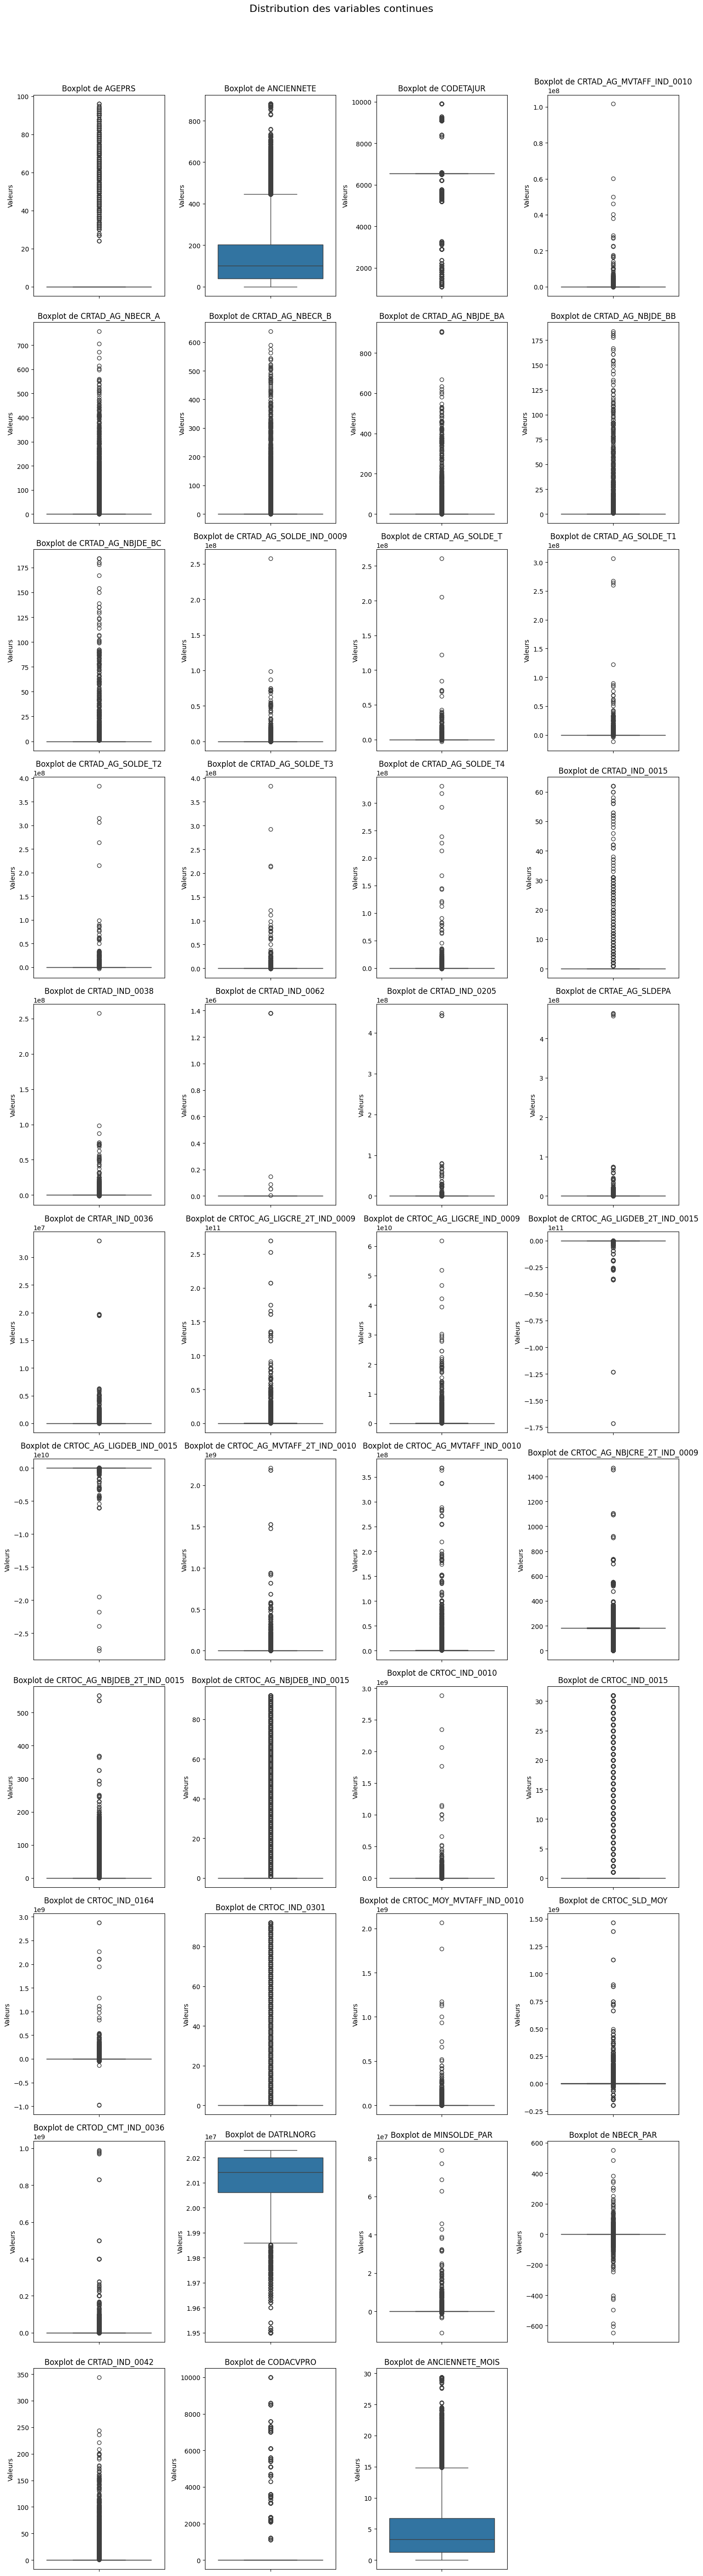

In [215]:
importlib.reload(functions)

functions.plot_boxplots(X_train,cont_vars,cols=4)

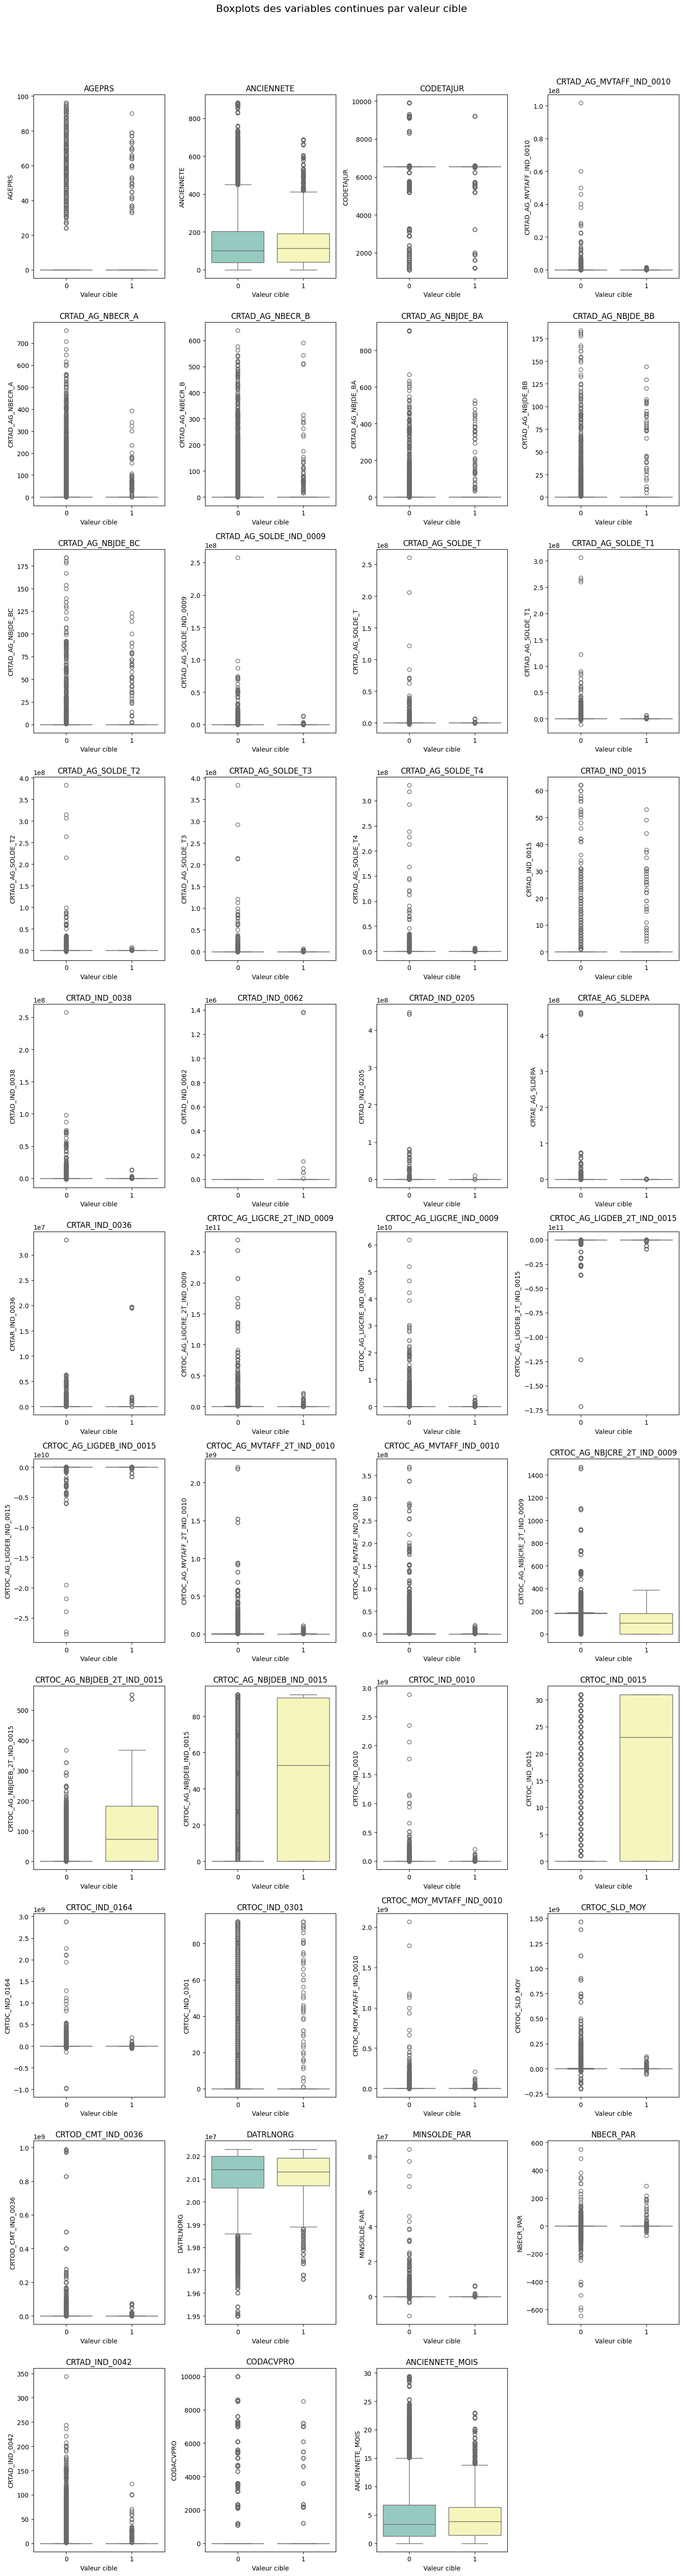

In [ ]:
functions.plot_boxplots_by_target(X_train, cont_vars, cible, cols=4)
# KDE plot
# rETRAIT DES OUTLIERS

In [ ]:
# importlib.reload(functions)
# summary_=functions.summarize_continuous_vars(X_train,cont_vars)

# functions.summarize_distribution_table(summary_)

{'High Dispersion (CV > 1)': ['AGEPRS',
  'CRTAD_AG_MVTAFF_IND_0010',
  'CRTAD_AG_NBECR_A',
  'CRTAD_AG_NBECR_B',
  'CRTAD_AG_NBJDE_BA',
  'CRTAD_AG_NBJDE_BB',
  'CRTAD_AG_NBJDE_BC',
  'CRTAD_AG_SOLDE_IND_0009',
  'CRTAD_AG_SOLDE_T',
  'CRTAD_AG_SOLDE_T1',
  'CRTAD_AG_SOLDE_T2',
  'CRTAD_AG_SOLDE_T3',
  'CRTAD_AG_SOLDE_T4',
  'CRTAD_IND_0015',
  'CRTAD_IND_0038',
  'CRTAD_IND_0062',
  'CRTAD_IND_0205',
  'CRTAE_AG_SLDEPA',
  'CRTAR_IND_0036',
  'CRTOC_AG_LIGCRE_2T_IND_0009',
  'CRTOC_AG_LIGCRE_IND_0009',
  'CRTOC_AG_LIGDEB_2T_IND_0015',
  'CRTOC_AG_LIGDEB_IND_0015',
  'CRTOC_AG_MVTAFF_2T_IND_0010',
  'CRTOC_AG_MVTAFF_IND_0010',
  'CRTOC_AG_NBJDEB_2T_IND_0015',
  'CRTOC_AG_NBJDEB_IND_0015',
  'CRTOC_IND_0010',
  'CRTOC_IND_0015',
  'CRTOC_IND_0164',
  'CRTOC_IND_0301',
  'CRTOC_MOY_MVTAFF_IND_0010',
  'CRTOC_SLD_MOY',
  'CRTOD_CMT_IND_0036',
  'MINSOLDE_PAR',
  'NBECR_PAR',
  'CRTAD_IND_0042',
  'CODACVPRO'],
 'Low Dispersion (CV < 0.1)': ['CODETAJUR', 'DATRLNORG'],
 'Highly Skewed (Ske

In [ ]:
### aNALYSE VISUELLE DES VARIABLES CONTINUES

#### II.2.2 Liaisons avec la variable cible

Utiliser des indicateurs tels que le HSIC, information mutuelle, en plus des indicateurs usuelles.

Question à poser : En regréssion logistique, on ne souhaite que chasser les liaisons monotones et linéaires entre les variables explicatives.

/!\ Attention à la définition de seuil pour ces indicateurs.

#### II.2.2 Liaisons entre les variables continues

#### II.2.3 Discrétisation des variables continues

In [ ]:
importlib.reload(functions)
if __name__ == '__main__':
    max_intervals = 4
    obj = functions.Discretization()
    intervals_by_variable = []  # Liste pour stocker les intervalles par variable
    
    for colName in ["CRTOC_AG_NBJDEB_IND_0015","CRTOC_AG_NBJDEB_2T_IND_0015"]:
        print('\nInterval for', colName)
        # Générer les intervalles
        intervals = obj.get_chimerge_intervals(X_train, colName, cible, max_intervals)
        
        # Ajouter les intervalles à la liste avec le nom de la variable
        intervals_by_variable.append({
            'variable': colName,
            'intervals': intervals
        })
        
        print(tabulate([[intervals]], tablefmt='fancy_grid'))

Data discretization process started

Interval for CRTOC_AG_NBJDEB_IND_0015
 Min chi square value is 324.5384852089385
╒═════════════════════════════════════════╕
│ [[0, 12], [13, 52], [53, 88], [89, 92]] │
╘═════════════════════════════════════════╛

Interval for CRTOC_AG_NBJDEB_2T_IND_0015
 Min chi square value is 286.288734894634
╒════════════════════════════════════════════╕
│ [[0, 20], [21, 64], [65, 177], [178, 552]] │
╘════════════════════════════════════════════╛


Stabilité des variables discrétisées

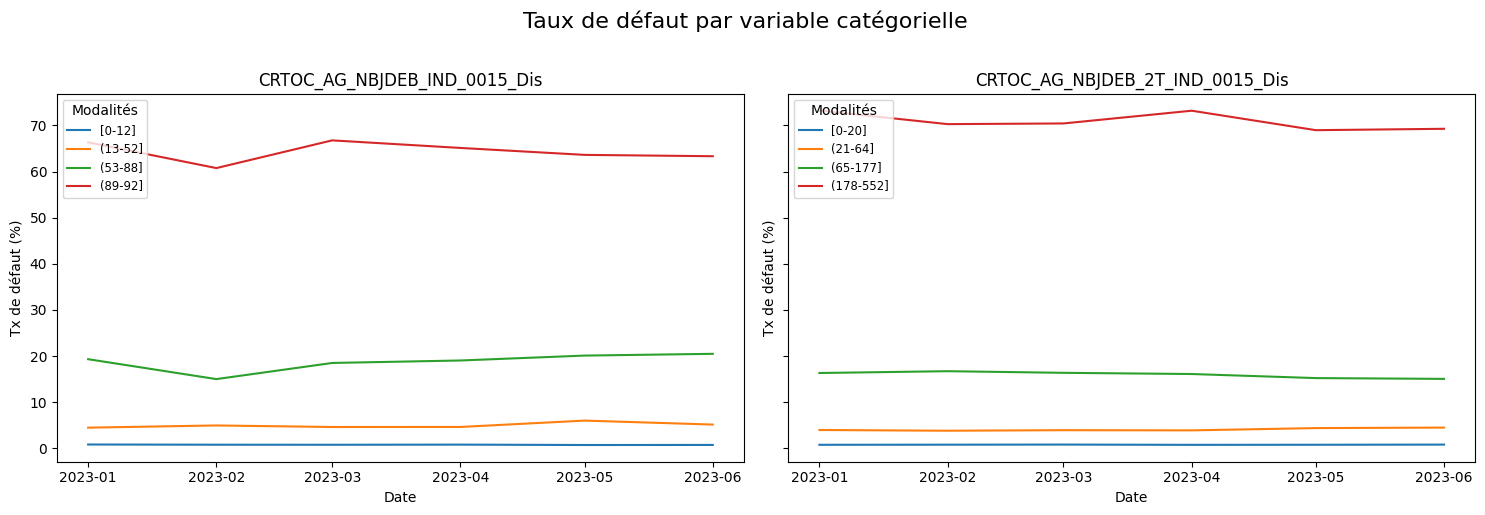

In [107]:
importlib.reload(functions)
dis_data,new_vars=functions.discretize_with_intervals(X_train, intervals_by_variable,date,cible)

dis_data.head()
functions.tx_rsq_par_var(dis_data,new_vars,date,cible)

### III. Construction du modèle

#### III.1. Régression logistique

Regression lasso, ridge, elastic, méthode stepwise, 